# Mount Drive, Installation, Import, HuggingFace Login

In [1]:
from google.colab import drive
import os

# 1. Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install --upgrade --quiet bitsandbytes datasets transformers peft trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 50.6 MB/s eta 0:00:00


In [3]:
import json
import PIL
from PIL import Image as PILImage
from tqdm import tqdm
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from transformers import AutoModelForImageTextToText, BitsAndBytesConfig, AutoProcessor,  pipeline
from datasets import load_dataset, concatenate_datasets, Image
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from trl import SFTConfig, SFTTrainer
import wandb

In [4]:
# Huggingface login
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HF_TOKEN'))


# Load Data from Drive
Remember to uncomment the part to download to colab local for faster training

In [5]:
train_size = 0.9  # @param {type: "number"}
validation_size = 0.1  # @param {type: "number"}

dataset = load_dataset("json", data_files="/content/drive/MyDrive/medgemma_contrastive_dataset.jsonl", split="train")

dataset_l = (dataset
    .select_columns(["image_l_cc_dm", "image_l_mlo_dm", "report_l_dm"])
    .rename_column("image_l_cc_dm", "cc_path")
    .rename_column("image_l_mlo_dm", "mlo_path")
    .rename_column("report_l_dm", "report"))

dataset_r = (dataset
    .select_columns(["image_r_cc_dm", "image_r_mlo_dm", "report_r_dm"])
    .rename_column("image_r_cc_dm", "cc_path")
    .rename_column("image_r_mlo_dm", "mlo_path")
    .rename_column("report_r_dm", "report"))

dataset = concatenate_datasets([dataset_l, dataset_r])

dataset = dataset.filter(lambda x: x['report'] is not None)
print(dataset[42])

data = dataset.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)

data["validation"] = data.pop("test") # Change test into validation
print(f"\nTrain split size: {len(data['train'])}\nValidation split size: {len(data['validation'])}\n")
data

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/652 [00:00<?, ? examples/s]

{'cc_path': '/content/drive/MyDrive/CDD-CESM-curated-dataset/images/P146_L_DM_CC.jpg', 'mlo_path': '/content/drive/MyDrive/CDD-CESM-curated-dataset/images/P146_L_DM_MLO.jpg', 'report': 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).'}

Train split size: 509
Validation split size: 57



DatasetDict({
    train: Dataset({
        features: ['cc_path', 'mlo_path', 'report'],
        num_rows: 509
    })
    validation: Dataset({
        features: ['cc_path', 'mlo_path', 'report'],
        num_rows: 57
    })
})

In [6]:
data['train'][0]

{'cc_path': '/content/drive/MyDrive/CDD-CESM-curated-dataset/images/P72_R_DM_CC.jpg',
 'mlo_path': None,
 'report': 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nTwo retroareolar and inner irregular high density masses with speculated margin are seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nTwo retroareolar and inner malignant looking masses (BIRADS 5).'}

## Move data from drive to Colab local environment

In [7]:
# !mkdir -p /content/local_images
# !cp -r /content/drive/MyDrive/CDD-CESM-curated-dataset/images/* /content/local_images/

In [8]:
# data = data.map(lambda x: {
#     "cc_path": x["cc_path"].replace("/content/drive/MyDrive/CDD-CESM-curated-dataset/images/", "/content/local_images/")  if x["cc_path"] else None,
#     "mlo_path": x["mlo_path"].replace("/content/drive/MyDrive/CDD-CESM-curated-dataset/images/", "/content/local_images/") if x["mlo_path"] else None
# })


In [9]:
data['train'][2]

{'cc_path': '/content/drive/MyDrive/CDD-CESM-curated-dataset/images/P192_R_DM_CC.jpg',
 'mlo_path': '/content/drive/MyDrive/CDD-CESM-curated-dataset/images/P192_R_DM_MLO.jpg',
 'report': 'ACR D: Extremely dense breasts.\n\nFindings: \nUpper outer benign macrocalcifications are noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcifications (BIRADS 2).'}

## Convert to chat template

In [10]:
def convert_to_user_content_template(example: dict[str, str]) -> list[dict[str, str]]:
    views_count = bool(example['cc_path']) + bool(example["mlo_path"]) # 2 if both views exist, 1 if only a single view exists

    PROMPT_BOTH_VIEWS = "Two images are provided: CC (craniocaudal) and MLO (mediolateral oblique) views of the same breast in this order. Generate a structured radiology report describing the findings and BIRADS assessment for this mammography exam."
    PROMPT_CC_ONLY = "A single CC (craniocaudal) view of the breast is provided. Generate a structured radiology report describing the findings and BIRADS assessment for this mammography image."
    PROMPT_MLO_ONLY = "A single MLO (mediolateral oblique) view of the breast is provided. Generate a structured radiology report describing the findings and BIRADS assessment for this mammography image."
    PROMPT = ""

    if views_count == 2:
        PROMPT = PROMPT_BOTH_VIEWS
    elif views_count == 1 and example['cc_path']:
        PROMPT = PROMPT_CC_ONLY
    elif views_count == 1 and example['mlo_path']:
        PROMPT = PROMPT_MLO_ONLY

    user_content = []
    for _ in range(views_count): # Append image tokens equals number of views
        user_content.append(
            {
                "type": "image",
            })

    user_content.append( # Append the prompt after the image tokens
        {
            "type": "text",
            "text": PROMPT,
        })

    return user_content

convert_to_user_content_template(data['train'][2])

[{'type': 'image'},
 {'type': 'image'},
 {'type': 'text',
  'text': 'Two images are provided: CC (craniocaudal) and MLO (mediolateral oblique) views of the same breast in this order. Generate a structured radiology report describing the findings and BIRADS assessment for this mammography exam.'}]

In [11]:
def format_data(example: dict[str, str]) -> dict[str, list]:

    example["messages"] = [
        {
            "role": "user",
            "content": convert_to_user_content_template(example),
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": example['report'],
                },
            ],
        },
    ]
    return example

data = data.map(format_data, remove_columns=["report"])

data = data.cast_column("cc_path", Image()).rename_column("cc_path", "cc_image")
data = data.cast_column("mlo_path", Image()).rename_column("mlo_path", "mlo_image")

data['train'][2]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

{'cc_image': <PIL.Image.Image image mode=RGB size=1140x1836>,
 'mlo_image': <PIL.Image.Image image mode=RGB size=1146x2118>,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': None, 'type': 'image'},
    {'text': 'Two images are provided: CC (craniocaudal) and MLO (mediolateral oblique) views of the same breast in this order. Generate a structured radiology report describing the findings and BIRADS assessment for this mammography exam.',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'ACR D: Extremely dense breasts.\n\nFindings: \nUpper outer benign macrocalcifications are noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcifications (BIRADS 2).',
     'type': 'text'}],
   'role': 'assistant'}]}

## Data Visualization

In [12]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_preformat = dataset.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)#.select_columns(['report'])

def extract_acr(text: str) -> str:
    """Extracts ACR density (A, B, C, D). Returns 'Unknown' if not found."""
    if not text: return "Unknown"
    # Matches "ACR" followed optionally by space/colon, then A-D
    pattern = r"ACR\s*[:\-]?\s*([ABCD])"
    match = re.search(pattern, text, re.IGNORECASE)
    return match.group(1).upper() if match else "Unknown"

def extract_birads(text: str) -> str:
    """Extracts BIRADS category (0-6). Returns 'Unknown' if not found."""
    if not text: return "Unknown"
    # Matches "BIRADS" followed optionally by space/colon, then 0-6
    pattern = r"BIRADS\s*[:\-]?\s*([0-6])"
    match = re.search(pattern, text, re.IGNORECASE)
    return match.group(1) if match else "Unknown"



In [13]:
def prepare_visualization_dataframe(dataset_dict):
    dfs = []

    for split_name in dataset_dict.keys():
        # Convert HF dataset to Pandas
        df = dataset_dict[split_name].to_pandas()

        # Apply extraction logic
        df['ACR'] = df['report'].apply(extract_acr)
        df['BIRADS'] = df['report'].apply(extract_birads)
        df['Split'] = split_name # Tag the source (Train vs Validation)

        dfs.append(df)

    # Combine into one huge DataFrame
    return pd.concat(dfs, ignore_index=True)

# Run the processing
full_df = prepare_visualization_dataframe(data_preformat)

# Sort values to ensure charts are ordered logically (1,2,3... and A,B,C...)
full_df = full_df.sort_values(by=['BIRADS', 'ACR'])

print(full_df)

                                               cc_path  \
8    /content/drive/MyDrive/CDD-CESM-curated-datase...   
20   /content/drive/MyDrive/CDD-CESM-curated-datase...   
29   /content/drive/MyDrive/CDD-CESM-curated-datase...   
56   /content/drive/MyDrive/CDD-CESM-curated-datase...   
60   /content/drive/MyDrive/CDD-CESM-curated-datase...   
..                                                 ...   
10   /content/drive/MyDrive/CDD-CESM-curated-datase...   
341  /content/drive/MyDrive/CDD-CESM-curated-datase...   
95                                                None   
55                                                None   
549  /content/drive/MyDrive/CDD-CESM-curated-datase...   

                                              mlo_path  \
8    /content/drive/MyDrive/CDD-CESM-curated-datase...   
20   /content/drive/MyDrive/CDD-CESM-curated-datase...   
29   /content/drive/MyDrive/CDD-CESM-curated-datase...   
56   /content/drive/MyDrive/CDD-CESM-curated-datase...   
60           

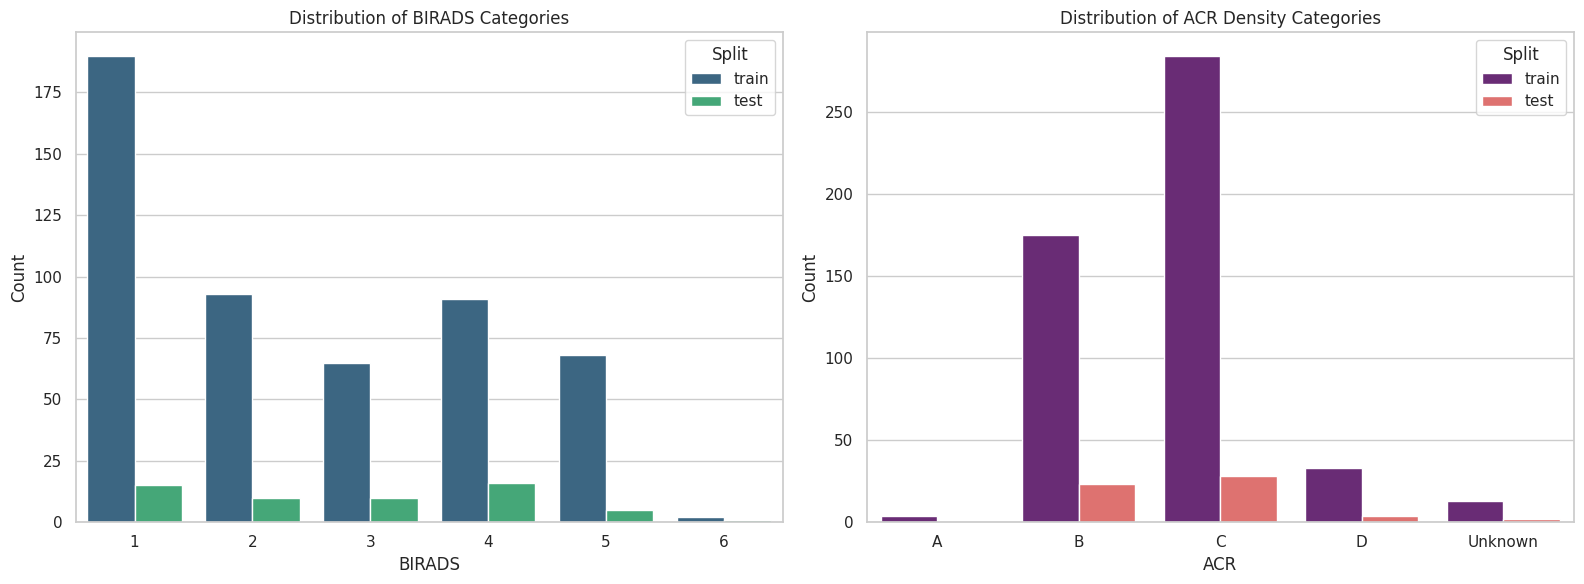

In [14]:
def plot_distributions(df):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: BIRADS Distribution
    sns.countplot(
        data=df,
        x="BIRADS",
        hue="Split",
        ax=axes[0],
        palette="viridis",
        order=sorted(df['BIRADS'].unique()) # Ensure order 1, 2, 3...
    )
    axes[0].set_title("Distribution of BIRADS Categories")
    axes[0].set_ylabel("Count")

    # Plot 2: ACR Distribution
    sns.countplot(
        data=df,
        x="ACR",
        hue="Split",
        ax=axes[1],
        palette="magma",
        order=sorted(df['ACR'].unique()) # Ensure order A, B, C...
    )
    axes[1].set_title("Distribution of ACR Density Categories")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

# Generate the charts
plot_distributions(full_df)

# Training process

## Config

In [ ]:
# "google/medgemma-4b-it" MedGemma base model
# "weijietling/medgemma-4b-it-contrastive-trained-130126" Medgemma + Contrastive training
# "weijietling/medgemma-4b-it-contrastive-trained-150126-mvs-ablation" Medgemma + Contrastive training without img_img_loss

# "medgemma-report-generation-5-epoch" MedGemma + Generative fine tuning
# "medgemma-contrastive-report-generation-5-epoch" MedGemma + Contrastive Training + Generative fine tuning
# "medgemma-contrastive-generation-mvs-ablation" Medgemma + Contrastive training without img_img_loss + Generative fine tuning



class Config:
    model_id = "weijietling/medgemma-4b-it-contrastive-trained-150126-mvs-ablation"
    output_dir = "medgemma-contrastive-generation-mvs-ablation"

    # Hyperparameters
    num_train_epochs = 5
    learning_rate = 2e-4
    lora_alpha = 32
    lora_r = 16
    lora_dropout = 0.05
    batch_size = 8
    gradient_accumulation_steps = 1


## Import model checkpoint
Contrastive trained medgemma-4b-it

In [ ]:
model_kwargs = dict(
    attn_implementation="sdpa",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(Config.model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(Config.model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

## Data Collator

In [ ]:
def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []

    transform = T.Compose([
                # 1. Random Resized Crop:
                T.RandomResizedCrop(size=(896, 896), scale=(0.7, 0.9), ratio=(0.45, 0.65)),

                # 2. Intensity/Contrast Jitter
                T.ColorJitter(brightness=0.2, contrast=0.2),

                # 3. Random Gaussian Blur
                T.RandomApply([T.GaussianBlur(kernel_size=19, sigma=(0.1, 2.0))], p=0.5)
            ])

    for example in examples:

        single_example_images = []
        if example["cc_image"]:
            image = example["cc_image"].convert("RGB")
            image = transform(image)
            single_example_images.append(image)
        if example["mlo_image"]:
            image = example["mlo_image"].convert("RGB")
            image = transform(image)
            single_example_images.append(image)

        images.append(single_example_images)

        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

## PEFT Config (LoRA)

In [ ]:
peft_config = LoraConfig(
    lora_alpha=Config.lora_alpha,
    lora_dropout=Config.lora_dropout,
    r=Config.lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

## WandB Logging Setup

In [ ]:
from google.colab import userdata
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')

config_dict = {k: v for k, v in vars(Config).items() if not k.startswith('_')}

logger = wandb.init(
    entity="wjlingz-none",
    project="medgemma-radiology-report",
    name="run-sft-v2",
    config=config_dict
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: wjlingz (wjlingz-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import torch
import wandb
from transformers import TrainerCallback
from PIL import Image

class WandbPredictionCallback(TrainerCallback):
    def __init__(self, processor, model, val_samples, num_samples=2):
        """
        We must pass the model instance here because Trainer doesn't pass it
        to on_evaluate automatically.
        """
        self.processor = processor
        self.model = model
        self.val_samples = val_samples[:num_samples]

    def on_evaluate(self, args, state, control, **kwargs):
        """
        Event called after evaluation loop triggers.
        """
        # Ensure model is in eval mode
        self.model.eval()

        columns = ["Step", "Image", "Ground Truth", "Generated Report"]
        data = []

        print(f"\n--- Generating predictions for step {state.global_step} ---")

        for sample in self.val_samples:
            # 1. Prepare Image (Prefer CC, fallback to MLO)
            image = sample["cc_image"] if sample["cc_image"] else sample["mlo_image"]
            if image is None: continue

            # Convert to RGB if needed
            if image.mode != "RGB":
                image = image.convert("RGB")

            # 2. Prepare Prompt
            original_messages = sample["messages"]

            # Get the ground truth report for logging
            ground_truth = "N/A"
            for msg in original_messages:
                if msg['role'] == 'assistant':
                    ground_truth = msg['content']

            # Create prompt for the model (User part only)
            prompt_messages = [msg for msg in original_messages if msg['role'] == 'user']
            prompt_text = self.processor.apply_chat_template(
                prompt_messages, add_generation_prompt=True, tokenize=False
            )

            # 3. Process Inputs
            inputs = self.processor(
                text=prompt_text,
                images=image,
                return_tensors="pt"
            )
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

            # 4. Generate
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=150,
                    do_sample=True,
                    temperature=0.7,
                    use_cache=True
                )

            # 5. Decode
            generated_text = self.processor.batch_decode(
                outputs[:, inputs["input_ids"].shape[1]:],
                skip_special_tokens=True
            )[0].strip()

            # 6. Add to table data
            display_image = image.resize((224, 224))
            data.append([
                state.global_step,
                wandb.Image(display_image),
                ground_truth,
                generated_text
            ])

        # Log to WandB
        wandb.log({"validation_samples": wandb.Table(data=data, columns=columns)})

        # Switch model back to train mode
        self.model.train()

## Trainer Parameter (SFT Config)

In [ ]:
args = SFTConfig(
    output_dir=Config.output_dir,                                     # Directory and Hub repository id to save the model to
    num_train_epochs=Config.num_train_epochs,                         # Number of training epochs
    per_device_train_batch_size=Config.batch_size,                    # Batch size per device during training
    per_device_eval_batch_size=Config.batch_size,                     # Batch size per device during evaluation
    gradient_accumulation_steps=Config.gradient_accumulation_steps,   # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                                      # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                                        # Use fused AdamW optimizer for better performance
    logging_steps=5,                                                  # Number of steps between logs
    save_strategy="epoch",                                            # Save checkpoint every epoch
    eval_strategy="steps",                                            # Evaluate every `eval_steps`
    eval_steps=5,                                                    # Number of steps between evaluations
    learning_rate=Config.learning_rate,                               # Learning rate based on QLoRA paper
    bf16=True,                                                        # Use bfloat16 precision
    max_grad_norm=0.3,                                                # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                                # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                                       # Use linear learning rate scheduler
    push_to_hub=True,                                                 # Push model to Hub
    report_to="wandb",                                                # Report metrics to tensorboard
    run_name="medgemma-sft-run-1",
    # metric_for_best_model="eval_loss",
    # load_best_model_at_end=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},           # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},                    # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                                    # Columns are unused for training but needed for data collator
    label_names=["labels"],                                           # Input keys that correspond to the labels
)

# Initialize the callback
validation_samples = [data["validation"][i] for i in range(2)]
vis_callback = WandbPredictionCallback(
    processor=processor,
    model=model,        # <--- Added this argument
    val_samples=validation_samples,
    num_samples=2
)

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(50)),  # Use subset of validation set for faster run
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
    #callbacks=[vis_callback]
)

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1225: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


# Train letsgooo

In [ ]:
from google.colab import runtime
import time

try:
    # 1. Run Training
    trainer.train()
    trainer.push_to_hub("Training completed successfully")
except Exception as e:
    print(f"❌ CRITICAL ERROR: {e}")
finally:
    print("⏳ Syncing WandB logs...")
    wandb.finish()

    print("⏳ Waiting 30s for background tasks...")
    time.sleep(30)

    print("👋 Disconnecting runtime.")
    runtime.unassign()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
5,4.875600,3.674754,4.063718,23278.000000,0.454139
10,2.604900,1.315659,6.727845,45948.000000,0.781584
15,0.955600,0.577424,7.481645,68724.000000,0.887310
20,0.467200,0.386362,0.391257,91950.000000,0.916098
25,0.291400,0.272607,0.095114,114294.000000,0.929115
30,0.189500,0.245333,0.068423,137732.000000,0.928561
35,0.187100,0.233905,0.084635,160045.000000,0.930889
40,0.197400,0.204114,0.106629,183031.000000,0.938306
45,0.175100,0.194807,0.069910,206055.000000,0.941826
50,0.181700,0.198537,0.055243,229085.000000,0.943601


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
5,4.875600,3.674754,4.063718,23278.000000,0.454139
10,2.604900,1.315659,6.727845,45948.000000,0.781584
15,0.955600,0.577424,7.481645,68724.000000,0.887310
20,0.467200,0.386362,0.391257,91950.000000,0.916098
25,0.291400,0.272607,0.095114,114294.000000,0.929115
30,0.189500,0.245333,0.068423,137732.000000,0.928561
35,0.187100,0.233905,0.084635,160045.000000,0.930889
40,0.197400,0.204114,0.106629,183031.000000,0.938306
45,0.175100,0.194807,0.069910,206055.000000,0.941826
50,0.181700,0.198537,0.055243,229085.000000,0.943601


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...blation/training_args.bin: 100%|##########| 6.42kB / 6.42kB            

  ...-ablation/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...s-ablation/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...adapter_model.safetensors:   2%|1         | 41.9MB / 2.76GB            

No files have been modified since last commit. Skipping to prevent empty commit.


⏳ Syncing WandB logs...


eval/entropy,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/mean_token_accuracy,▁▇██████████████████████████████████████
eval/num_tokens,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/runtime,▅▃▇▅▄█▆▅▇▄▃▃▆▂▅▅▂▅▁▂▄▂▃▄█▆▃▅▅▂█▂▅▃▂▁▇▄▄▄
eval/samples_per_second,▆▃▅▂▃▂▂▅▂▂▆▅▂▄█▆▂▃▇▅▇▅▅▄▁▃▅▅▂▃▆▄▃▁▃▄▇▂▄▃
eval/steps_per_second,▆▃▅▂▃▄▂▃▅▅▃▂▄▅▅▃▆█▃▆▃▇▅▅▇▇▅▁▆▃▆▃▁▃▅▇▂▄▄▅
train/entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
+5,...


⏳ Waiting 30s for background tasks...
👋 Disconnecting runtime.


In [ ]:
# Attention: "sdpa"   Batch: 1    Grad acc step: 4    Epoch: 1    Vram Usage: 25.9GB      Eval_step: 5      Training time: 45 minutes
# Attention: "sdpa"   Batch: 8    Grad acc step: 4    Epoch: 1    Vram Usage: 70.9GB (accurate?)      Eval_step: 50      Training time: 7 minutes


# Evaluation

## Load model through pipeline

In [22]:
# Configure Quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

generator = pipeline(
    "image-text-to-text",
    # model="weijietling/medgemma-contrastive-report-generation-5-epoch",
    # model = "weijietling/medgemma-report-generation-5-epoch",
    model = "weijietling/medgemma-contrastive-generation-mvs-ablation",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    model_kwargs={"quantization_config": bnb_config} # Comment this line out to avoid quantization
)

generator.model.generation_config.do_sample = False
processor = generator.processor

# processor.tokenizer.padding_side = "right" # Generation should use left padding, but right padding sometimes have better performance
# 9.8GB VRAM with quantization

adapter_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1225: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


adapter_model.safetensors:   0%|          | 0.00/2.76G [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# import torch
# import gc
# del model, processor, generator
# gc.collect()
# torch.cuda.empty_cache()


## Batch inference

In [23]:
# # Single Inference Example
# split = "train" # @param ["validation","train"]
# sample_index = 180 # @param {type: "number"}

# cc_image = data[split][sample_index]['cc_image']
# mlo_image = data[split][sample_index]['mlo_image']
# prompt = data[split][sample_index]['messages'][0]['content'][2]['text']
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "image": cc_image},
#             {"type": "image", "image": mlo_image},
#             {"type": "text", "text": prompt},
#         ],
#     }
# ]

# t = generator(messages)

# print("\nGenerated report:\n")
# print(t[0]["generated_text"][-1]['content'])

# print("\nTruth report:\n")
# print(data[split][sample_index]['messages'][1]['content'][0]['text'])

In [24]:
def convert_to_message_format(sample):
    views_count = 0
    if sample['cc_image']: views_count += 1
    if sample['mlo_image']: views_count += 1
    prompt = sample['messages'][0]['content'][-1]['text']

    if views_count == 1:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample.get('cc_image') or sample.get('mlo_image')},
                    {"type": "text", "text": prompt},
                ],
            }
        ]

    if views_count == 2:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample.get('cc_image')},
                    {"type": "image", "image": sample.get('mlo_image')},
                    {"type": "text", "text": prompt},
                ],
            }
        ]

    return messages

def data_generator(dataset, batch_size):
    batch = []
    original_sentences = []
    for item in dataset:
        messages = convert_to_message_format(item)

        batch.append(messages)
        original_sentences.append(item['messages'][-1]['content'][0]['text'])

        if len(batch) == batch_size:
            yield batch, original_sentences
            batch = []
            original_sentences = []


    if batch: yield batch, original_sentences

In [25]:
# Start running batch inference
original_sentences = []
generated_sentences = []
print("Starting inference...")

batch_size = 16
for input_batch, original_sentences_batch in tqdm(data_generator(data["validation"], batch_size = batch_size)):
    responses = generator(input_batch, batch_size = batch_size)

    for response in responses: # Stitch generated_text one by one
      generated_text = response[0]["generated_text"][-1]['content']
      generated_sentences.append(generated_text)

    original_sentences += original_sentences_batch

Starting inference...


4it [01:25, 21.27s/it]


## Report Metrics

### Metric definition

In [26]:
!pip install --quiet evaluate rouge_score nltk absl-py pycocoevalcap

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, cohen_kappa_score
import re
import numpy as np

import evaluate
import collections
import numpy as np
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from pycocoevalcap.cider.cider import Cider
from typing import List, Dict

def extract_category(pattern: str, text: str) -> str:
    target = None
    match = re.search(pattern, text)
    if match:
        target = match.group(1)
    return target

def extract_birads(text: str) -> str:
    return extract_category(r"BIRADS ([12345])", text)

def extract_acr(text: str) -> str:
    return extract_category(r"ACR ([ABCD])", text)

def extract_classification_truth_table(generated_sentences, original_sentences):
    birads_truth_table = []
    acr_truth_table = []
    for generated, original in zip(generated_sentences, original_sentences):
        generated_birads = extract_birads(generated)
        original_birads = extract_birads(original)
        generated_acr = extract_acr(generated)
        original_acr = extract_acr(original)
        birads_truth_table.append([generated_birads, original_birads])
        acr_truth_table.append([generated_acr, original_acr])

    return birads_truth_table, acr_truth_table

def report_classification_metrics(birads_truth_table, acr_truth_table, debug=False):

    # Remove None
    birads_truth_table = np.array([birads for birads in birads_truth_table if birads[0] is not None and birads[1] is not None])
    acr_truth_table = np.array([acr for acr in acr_truth_table if acr[0] is not None and acr[1] is not None])

    # Confusion matrix
    birads_cm = confusion_matrix(birads_truth_table[:,1], birads_truth_table[:,0])
    acr_cm = confusion_matrix(acr_truth_table[:,1], acr_truth_table[:,0])

    # Classification Report
    birads_cr = classification_report(birads_truth_table[:,1], birads_truth_table[:,0], labels=['1','2','3','4', '5'], target_names=[f"BIRADS {i}" for i in range(1, 6)], zero_division=0)
    acr_cr = classification_report(acr_truth_table[:,1], acr_truth_table[:,0], labels=['A','B','C','D'], target_names=[f"ACR {i}" for i in ['A','B','C','D']], zero_division=0)

    if debug:
        print(f"BIRADS Classification: \n{birads_cm}\n{birads_cr}")
        print(f"ACR Classification: \n{acr_cm}\n{acr_cr}")

    birads_accuracy = np.sum(birads_cm.diagonal()) / np.sum(birads_cm)
    acr_accuracy = np.sum(acr_cm.diagonal()) / np.sum(acr_cm)
    return birads_accuracy, acr_accuracy


# Check/Download NLTK resources quietly
needed_resources = ['punkt_tab', 'wordnet', 'omw-1.4'] # Added omw-1.4 for Meteor
for resource in needed_resources:
    try:
        # Check if it exists
        if resource == 'punkt_tab':
            nltk.data.find('tokenizers/punkt_tab')
        else:
            nltk.data.find(f'corpora/{resource}')
    except LookupError:
        # Download quietly if missing
        nltk.download(resource)

# Load HuggingFace metrics ONCE globally
# This prevents them from initializing/checking NLTK every time you call the function
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

def _compute_f1(preds_tokens: List[List[str]], refs_tokens: List[List[str]]) -> float:
    """Helper to calculate Macro-averaged Unigram F1."""
    f1_scores = []
    for pred, ref in zip(preds_tokens, refs_tokens):
        pred_counts = collections.Counter(pred)
        ref_counts = collections.Counter(ref)

        overlap = sum((pred_counts & ref_counts).values())
        if overlap == 0:
            f1_scores.append(0.0)
            continue

        precision = overlap / len(pred)
        recall = overlap / len(ref)
        f1_scores.append(2 * (precision * recall) / (precision + recall))

    return float(np.mean(f1_scores))

def compute_metrics(generated_sentences: List[str], original_sentences: List[str], debug = False) -> Dict[str, float]:
    """
    Computes BLEU-1/2/3/4, ROUGE-1/2/L, METEOR, CIDEr, and Token F1.
    """
    # 0. Remove boilerplate content from the sentences
    original_sentences = remove_boilerplate(original_sentences)
    generated_sentences = remove_boilerplate(generated_sentences)

    # 1. Preprocessing & Format Setup
    refs_tokenized = [[word_tokenize(ref.lower())] for ref in original_sentences]
    preds_tokenized = [word_tokenize(pred.lower()) for pred in generated_sentences]

    # CIDEr expects {img_id: [ref]}
    refs_list = [[ref] for ref in original_sentences]
    cider_gts = {i: [ref] for i, ref in enumerate(original_sentences)}
    cider_res = {i: [pred] for i, pred in enumerate(generated_sentences)}

    # 2. ROUGE & METEOR (HuggingFace Evaluate)
    rouge = rouge_metric.compute(
        predictions=generated_sentences,
        references=original_sentences,
        use_stemmer=True
    )
    meteor = meteor_metric.compute(
        predictions=generated_sentences,
        references=original_sentences
    )

    # 3. BLEU (NLTK)
    # Weights correspond to BLEU-1 through BLEU-4
    bleu_weights = [
        ("bleu1", (1.0, 0, 0, 0)),
        ("bleu2", (0.5, 0.5, 0, 0)),
        ("bleu3", (0.33, 0.33, 0.33, 0)),
        ("bleu4", (0.25, 0.25, 0.25, 0.25)),
    ]
    bleu_scores = {
        name: corpus_bleu(refs_tokenized, preds_tokenized, weights=w)
        for name, w in bleu_weights
    }

    # 4. CIDEr (pycocoevalcap)
    cider_score, _ = Cider().compute_score(cider_gts, cider_res)

    # 5. F1 Score (Manual Tokenization)
    preds_toks = [word_tokenize(s.lower()) for s in generated_sentences]
    refs_toks = [word_tokenize(s.lower()) for s in original_sentences]
    f1_score = _compute_f1(preds_toks, refs_toks)

    # 6. Clinical metrics accuracies
    birads_truth_table, acr_truth_table = extract_classification_truth_table(generated_sentences,  original_sentences)
    birads_accuracy, acr_accuracy = report_classification_metrics(birads_truth_table, acr_truth_table, debug)

    all_classes=[1, 2, 3, 4, 5]
    preds = np.array([birads for birads in birads_truth_table if birads[0] is not None and birads[1] is not None])[:,0].astype(int)
    truth = np.array([birads for birads in birads_truth_table if birads[0] is not None and birads[1] is not None])[:,1].astype(int)
    mae = mean_absolute_error(truth, preds)
    qwk = cohen_kappa_score(truth, preds, weights='quadratic', labels=all_classes)


    # 7. Aggregate Results
    metrics = {
        "bleu1": bleu_scores["bleu1"],
        "bleu2": bleu_scores["bleu2"],
        "bleu3": bleu_scores["bleu3"],
        "bleu4": bleu_scores["bleu4"],
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "meteor": meteor["meteor"],
        "cider": cider_score,
        "f1": f1_score,
        "birads_accuracy": birads_accuracy,
        "birads_mae": mae,
        "birads_qwk": qwk,
        "acr_accuracy": acr_accuracy
    }

    return {k: f"{v:.4f}" for k, v in metrics.items()}

def remove_boilerplate(sentences:list[str]) -> list[str]:
    cleaned_sentences = []
    for sentence in sentences:

        acr = ""
        finding = ""
        opinion = ""

        # Added flags=re.DOTALL so (.) can see past the first line
        acr_match = re.search(r"(ACR .):", sentence)
        finding_match = re.search(r"Findings:(.*)Opinion:(.*)", sentence, flags=re.DOTALL)

        if acr_match:
            acr = acr_match.group(1).strip() + ". "
        if finding_match:
            finding = finding_match.group(1).strip()
            opinion = finding_match.group(2).strip()

        cleaned_sentence = re.sub(r"\s+"," ",f"{acr}{finding} {opinion}")
        cleaned_sentences.append(cleaned_sentence)
    return cleaned_sentences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Compute metric

In [28]:
metric = compute_metrics(generated_sentences, original_sentences, debug=True)
print(metric)

BIRADS Classification: 
[[12  1  1  0  1]
 [ 4  3  3  0  0]
 [ 3  1  3  2  1]
 [ 8  1  2  2  3]
 [ 0  0  1  1  3]]
              precision    recall  f1-score   support

    BIRADS 1       0.44      0.80      0.57        15
    BIRADS 2       0.50      0.30      0.38        10
    BIRADS 3       0.30      0.30      0.30        10
    BIRADS 4       0.40      0.12      0.19        16
    BIRADS 5       0.38      0.60      0.46         5

    accuracy                           0.41        56
   macro avg       0.40      0.42      0.38        56
weighted avg       0.41      0.41      0.37        56

ACR Classification: 
[[20  3  0]
 [ 3 25  0]
 [ 0  4  0]]
              precision    recall  f1-score   support

       ACR A       0.00      0.00      0.00         0
       ACR B       0.87      0.87      0.87        23
       ACR C       0.78      0.89      0.83        28
       ACR D       0.00      0.00      0.00         4

    accuracy                           0.82        55
   macro avg

In [ ]:
{ # Model with quantization config + right padding (Contrastive training + Generative fine tuning) 5-epoch version
    'bleu1': '0.7622','0.6439'
    'bleu2': '0.7127','0.5783'
    'bleu3': '0.6750','0.5252'
    'bleu4': '0.6467','0.4841'
    'rouge1': '0.6759',
    'rouge2': '0.5422',
    'rougeL': '0.6560',
    'meteor': '0.6692',
    'cider': '2.2327',
    'f1': '0.7127',
    'birads_accuracy': '0.4286',
    'birads_mae': '0.8929',
    'birads_qwk': '0.5915',
    'acr_accuracy': '0.8727'
}

"""
BIRADS Classification:
[[14  1  0  0  0]
 [ 4  3  3  0  0]
 [ 3  0  4  2  1]
 [ 5  3  2  1  5]
 [ 0  0  1  2  2]]
              precision    recall  f1-score   support

    BIRADS 1       0.54      0.93      0.68        15
    BIRADS 2       0.43      0.30      0.35        10
    BIRADS 3       0.40      0.40      0.40        10
    BIRADS 4       0.20      0.06      0.10        16
    BIRADS 5       0.25      0.40      0.31         5

    accuracy                           0.43        56
   macro avg       0.36      0.42      0.37        56
weighted avg       0.37      0.43      0.37        56

ACR Classification:
[[21  2  0]
 [ 2 28  0]
 [ 0  4  0]]
              precision    recall  f1-score   support

       ACR A       0.00      0.00      0.00         0
       ACR B       0.91      0.91      0.91        23
       ACR C       0.82      0.93      0.88        30
       ACR D       0.00      0.00      0.00         4

    accuracy                           0.86        57
   macro avg       0.43      0.46      0.45        57
weighted avg       0.80      0.86      0.83        57
"""

'\nBIRADS Classification: \n[[14  1  0  0  0]\n [ 4  3  3  0  0]\n [ 3  0  4  2  1]\n [ 5  3  2  1  5]\n [ 0  0  1  2  2]]\n              precision    recall  f1-score   support\n\n    BIRADS 1       0.54      0.93      0.68        15\n    BIRADS 2       0.43      0.30      0.35        10\n    BIRADS 3       0.40      0.40      0.40        10\n    BIRADS 4       0.20      0.06      0.10        16\n    BIRADS 5       0.25      0.40      0.31         5\n\n    accuracy                           0.43        56\n   macro avg       0.36      0.42      0.37        56\nweighted avg       0.37      0.43      0.37        56\n\nACR Classification: \n[[21  2  0]\n [ 2 28  0]\n [ 0  4  0]]\n              precision    recall  f1-score   support\n\n       ACR A       0.00      0.00      0.00         0\n       ACR B       0.91      0.91      0.91        23\n       ACR C       0.82      0.93      0.88        30\n       ACR D       0.00      0.00      0.00         4\n\n    accuracy                      

In [ ]:
{ # Ablation Study: Model (MVS-Ablated Contrastive training + Generative fine tuning) 5-epoch version
    'bleu1': '0.7577','0.6174'
    'bleu2': '0.7009','0.5516'
    'bleu3': '0.6587','0.4984'
    'bleu4': '0.6280','0.4568'
    'rouge1': '0.6433',
    'rouge2': '0.5085',
    'rougeL': '0.6183',
    'meteor': '0.6409',
    'cider': '2.0378',
    'f1': '0.6854',
    'birads_accuracy': '0.4107',
    'birads_mae': '1.0536'
    'birads_qwk': '0.4400',
    'acr_accuracy': '0.7895'
}


"""
BIRADS Classification:
[[12  1  1  0  1]
 [ 4  3  3  0  0]
 [ 3  1  3  2  1]
 [ 8  1  2  2  3]
 [ 0  0  1  1  3]]
              precision    recall  f1-score   support

    BIRADS 1       0.44      0.80      0.57        15
    BIRADS 2       0.50      0.30      0.38        10
    BIRADS 3       0.30      0.30      0.30        10
    BIRADS 4       0.40      0.12      0.19        16
    BIRADS 5       0.38      0.60      0.46         5

    accuracy                           0.41        56
   macro avg       0.40      0.42      0.38        56
weighted avg       0.41      0.41      0.37        56

ACR Classification:
[[20  3  0]
 [ 5 25  0]
 [ 0  4  0]]
              precision    recall  f1-score   support

       ACR A       0.00      0.00      0.00         0
       ACR B       0.80      0.87      0.83        23
       ACR C       0.78      0.83      0.81        30
       ACR D       0.00      0.00      0.00         4

    accuracy                           0.79        57
   macro avg       0.40      0.43      0.41        57
weighted avg       0.73      0.79      0.76        57
"""



'\nBIRADS Classification: \n[[12  1  1  0  1]\n [ 4  3  3  0  0]\n [ 3  1  3  2  1]\n [ 8  1  2  2  3]\n [ 0  0  1  1  3]]\n              precision    recall  f1-score   support\n\n    BIRADS 1       0.44      0.80      0.57        15\n    BIRADS 2       0.50      0.30      0.38        10\n    BIRADS 3       0.30      0.30      0.30        10\n    BIRADS 4       0.40      0.12      0.19        16\n    BIRADS 5       0.38      0.60      0.46         5\n\n    accuracy                           0.41        56\n   macro avg       0.40      0.42      0.38        56\nweighted avg       0.41      0.41      0.37        56\n\nACR Classification: \n[[20  3  0]\n [ 5 25  0]\n [ 0  4  0]]\n              precision    recall  f1-score   support\n\n       ACR A       0.00      0.00      0.00         0\n       ACR B       0.80      0.87      0.83        23\n       ACR C       0.78      0.83      0.81        30\n       ACR D       0.00      0.00      0.00         4\n\n    accuracy                      

In [ ]:
{  # Ablation Study: Quantized MedGemma + Generative fine tuning (No contrastive alignment phase)
    'bleu1': '0.7570','0.6097'
    'bleu2': '0.6997','0.5363'
    'bleu3': '0.6566','0.4804'
    'bleu4': '0.6251','0.4384'
    'rouge1': '0.6342',
    'rouge2': '0.4834',
    'rougeL': '0.6042',
    'meteor': '0.6231',
    'cider': '1.6608',
    'f1': '0.6791',
    'birads_accuracy': '0.4107',
    'birads_mae': '1.0357',
    'birads_qwk': '0.4538',
    'acr_accuracy': '0.5263' # Mode collapse
}


{'bleu1': '0.7570',
 '0.6097bleu2': '0.6997',
 '0.5363bleu3': '0.6566',
 '0.4804bleu4': '0.6251',
 '0.4384rouge1': '0.6342',
 'rouge2': '0.4834',
 'rougeL': '0.6042',
 'meteor': '0.6231',
 'cider': '1.6608',
 'f1': '0.6791',
 'birads_accuracy': '0.4107',
 'acr_accuracy': '0.5263'}

In [ ]:
{ # Model with quantization config + right padding (Contrastive training + Generative fine tuning)
    'bleu1': '0.7239',
    'bleu2': '0.6722',
    'bleu3': '0.6326',
    'bleu4': '0.6034',
    'rouge1': '0.6335',
    'rouge2': '0.4918',
    'rougeL': '0.6060',
    'meteor': '0.6148',
    'cider': '1.6801',
    'f1': '0.6773',
    'birads_accuracy': '0.3929',
    'acr_accuracy': '0.5263'
}


{'bleu1': '0.7239',
 'bleu2': '0.6722',
 'bleu3': '0.6326',
 'bleu4': '0.6034',
 'rouge1': '0.6335',
 'rouge2': '0.4918',
 'rougeL': '0.6060',
 'meteor': '0.6148',
 'cider': '1.6801',
 'f1': '0.6773',
 'birads_accuracy': '0.3929',
 'acr_accuracy': '0.5263'}

In [ ]:
{ # Model with quantization config + left padding (Contrastive training + Generative fine tuning)
    'bleu1': '0.7243',
    'bleu2': '0.6720',
    'bleu3': '0.6315',
    'bleu4': '0.6017',
    'rouge1': '0.6306',
    'rouge2': '0.4879',
    'rougeL': '0.6021',
    'meteor': '0.6118',
    'cider': '1.6724',
    'f1': '0.6745',
    'birads_accuracy':'0.3929',
    'acr_accuracy': '0.5263'
}




{'bleu1': '0.7243',
 'bleu2': '0.6720',
 'bleu3': '0.6315',
 'bleu4': '0.6017',
 'rouge1': '0.6306',
 'rouge2': '0.4879',
 'rougeL': '0.6021',
 'meteor': '0.6118',
 'cider': '1.6724',
 'f1': '0.6745',
 'birads_accuracy': '0.3929',
 'acr_accuracy': '0.5263'}

In [ ]:
{ # No quantization model performance (Contrastive training + Generative fine tuning)
    'bleu1': '0.7053',
    'bleu2': '0.6516',
    'bleu3': '0.6104',
    'bleu4': '0.5809',
    'rouge1': '0.6263',
    'rouge2': '0.4914',
    'rougeL': '0.5955',
    'meteor': '0.6011',
    'cider': '1.7679',
    'f1': '0.6718',
    'birads_accuracy': '0.3750',
    'acr_accuracy': '0.5263'
}

{'bleu1': '0.7053',
 'bleu2': '0.6516',
 'bleu3': '0.6104',
 'bleu4': '0.5809',
 'rouge1': '0.6263',
 'rouge2': '0.4914',
 'rougeL': '0.5955',
 'meteor': '0.6011',
 'cider': '1.7679',
 'f1': '0.6718',
 'birads_accuracy': '0.3750',
 'acr_accuracy': '0.5263'}

In [ ]:
{ # Dumbass model performance (Contrastive training with wrong setup i.e. data leakage + Generative fine tuning)
    'bleu1': '0.6733',
    'bleu2': '0.6225',
    'bleu3': '0.5827',
    'bleu4': '0.5540',
    'rouge1': '0.6108',
    'rouge2': '0.4734',
    'rougeL': '0.5834',
    'meteor': '0.5885',
    'cider': '1.5362',
    'f1': '0.6601',
    'birads_accuracy': '0.3036',
    'acr_accuracy': '0.5263'
 }


{'bleu1': '0.6733',
 'bleu2': '0.6225',
 'bleu3': '0.5827',
 'bleu4': '0.5540',
 'rouge1': '0.6108',
 'rouge2': '0.4734',
 'rougeL': '0.5834',
 'meteor': '0.5885',
 'cider': '1.5362',
 'f1': '0.6601',
 'birads_accuracy': '0.3036',
 'acr_accuracy': '0.5263'}

# Ignore

In [3]:
original_sentences = ['ACR B: Scattered fibroglandular tissue.\n\nFindings: \nInner oval shaped equal density mass with obscured margin is noted.\nLower inner benign macrocalcification is noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nInner benign looking mass (BIRADS 3).\nLower inner benign macrocalcification (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper high density irregular shaped mass with speculated margin is seen.\nIt is seen reaching to the skin with focal indentation as well as retracting the nipple.\n\nOpinion: \nUpper malignant looking mass with focal skin and nipple retraction (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nMultiple retroareolar rounded equal density masses with circumscribed margin are seen associated with retroareolar increased density that is tubular in shape likely dilated ducts.\nAnother upper outer quadrant rounded equal density mass with circumscribed margin is also seen.\nFew scattered benign macrocalcifications are noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nMultiple retroareolar and upper outer benign looking masses (BIRADS 3).\nDilated retroareolar ducts (BIRADS 2).\nFew scattered benign macrocalcifications (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nUpper outer quadrant IMLN is noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer IMLN (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant IMLN is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer IMLN (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nLower central and inner focal asymmetrical increased density is seen.\nUpper outer IMLN is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower central and inner focal asymmetry along with IMLN (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer asymmetry (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral outer oval shaped equal density mass with circumscribed margin is seen.\nUpper outer benign macrocalcification is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nCentral outer benign looking mass (BIRADS 3).\nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogeneously dense breasts.\n\nFindings: \nUpper central and inner benign macrocalcifications.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and inner benign macrocalcifications (BIRADS 2).',
 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper irregular high density mass with speculated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper malignant looking mass (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower central and outer irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower central and outer suspicious looking mass (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nRegional microcalcifications with clusters and edema pattern are noted.\n\nOpinion: \nRegional suspicious looking microcalcifications associated with edema pattern (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer axillary tail irregular high density mass with speculated margin and ductal extension with scattered calcifications are noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer axillary tail malignant looking mass with ductal extension and scattered calcifications (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nUpper outer IMLN is noted.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).\nUpper outer IMLN (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower inner quadrant focal asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner focal asymmetry (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral inner quadrant rounded high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nCentral inner suspicious looking mass (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper irregular high density mass with speculated margin is seen with surrounding nodules and calcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper suspicious looking mass with surrounding nodules and calcifications (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral rounded high density mass with indistinct margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nCentral suspicious looking mass and edema pattern (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer central irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer central suspicious looking mass (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nInner irregular high density mass with speculated margin is seen with nipple retraction.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nInner malignant looking mass with nipple retraction (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'Findings: \nStatus postoperative showing operative scar and edema.\nRetroareolar benign macrocalcifications.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar and edema showing no evidence of recurrent lesions (BIRADS 2).\nRetroareolar benign macrocalcification (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper benign macrocalcifications are noted.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nUpper benign macrocalcifications (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nUpper outer quadrant focal asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer focal asymmetry (BIRADS 3).\nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central irregular high density mass with indistinct margin is seen associated with two adjacent small irregular equal density masses with indistinct margin.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central suspicious looking mass associated with two adjacent smaller masses (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nRetroareolar focal asymmetrical increased density is noted. \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nRetroareolar focal asymmetry (BIRADS 3).',
 'Findings: \nStatus postoperative showing operative scar with no speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar showing no evidence of recurrent lesions (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae is seen associated with retroareolar architectural distortion.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes associated with retroareolar architectural distortion (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breast.\n\nFindings: \nACR C: Heterogenously dense breast.\nLower architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower architectural distortion (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nStatus post neoadjuvant chemotherapy of a known case of breast cancer showing diffuse edematous changes (BIRADS 6).',
 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central architectural distortion is noted.\nNo suspicious microcalcifications.\nNormal skin thickness.\n\nOpinion: \nUpper central suspicious looking architectural distortion (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae associated with diffuse air/dark density.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes associated with regional air/dark density (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant benign macrocalcifications are noted.\nUpper outer and central asymmetrical increased density associated with retroareolar increased density that is tubular in shape likely prominent duct system.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcificaions (BIRADS 2).\nUpper outer and central asymmetry with prominent retroareolar duct system (BIRADS 3).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nACR C: Heterogenously dense breasts.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogeneously dense breasts.\n\nFindings: \nUpper central architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central architectural distortion (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral irregular high density masses with speculated margin and edema pattern are seen.\nAssociated upper outer and central asymmetrical increased density with overlying microcalcifications are noted.\n\nOpinion: \nCentral malignant looking masses and edema pattern associated with upper outer and central asymmetry with overlying suspicious microcalcifications (BIRADS 5).',
 'ACR D: Extremely dense breasts.\n\nFindings: \nUpper central and outer irregular high density mass with speculated margin is seen.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and outer suspicious looking mass (BIRADS 4).',
 'ACR C: Heterogenously enhancing breasts.\n\nFindings: \nUpper outer and inner quadrants IMLNs are noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer and inner IMLNs (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nRetroareolar increased density that is tubular in shape likely dilated duct.\nNormal skin thickness and contour of breast.\n\nOpinion: \nDilated retroareolar duct (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with indistinct margin is seen with overlying cluster of microcalcification.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass with overlying suspicious microcalcification (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nStatus postoperative showing operative scar with upper central deeply seated focal asymmetrical increased density.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar showing suspicious upper central deeply seated focal asymmetry (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper inner quadrant asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper inner asymmetry (BIRADS 3).']

In [4]:
# Generated from best model
generated_sentences = ['ACR B: Scattered fibroglandular tissue.\n\nFindings: \nLower inner quadrant oval shaped equal density mass with circumscribed margin is seen.\nUpper outer benign macrocalcification is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner benign looking mass (BIRADS 3).\nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper central high density rounded mass with obscured margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central suspicious looking mass (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant rounded equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant oval shaped equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nLower inner quadrant oval shaped equal density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner quadrant suspicious looking mass (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant oval shaped equal density mass with partially obscured lobulated margin is seen.\nUpper outer IMLN is also noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).\nUpper outer IMLN (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant benign macrocalcifications are noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcifications (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper architectural distortion (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central and outer focal asymmetrical increased density with overlying segmental microcalcifications are seen. \nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and outer malignant looking focal asymmetry with overlying suspicious microcalcifications (BIRADS 5).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant irregular high density mass with speculated margin and overlying microcalcifications is seen.\nCentral inner benign macrocalcification is noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer quadrant malignant looking mass with overlying microcalcifications (BIRADS 5).\nCentral inner benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with speculated margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nUpper outer malignant looking mass and edema pattern (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central irregular high density mass with speculated margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nUpper central malignant looking mass and edema pattern (BIRADS 5).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper central inner rounded high density mass with circumscribed margin is seen.\nOuter IMLN is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nOuter IMLN (BIRADS 2).\nUpper central inner suspicious looking mass (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral and lower inner asymmetrical increased density is noted with overlying macrocalcifications.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nCentral and lower inner asymmetry with overlying macrocalcifications (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower inner irregular high density mass with speculated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner malignant looking mass (BIRADS 5).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central inner irregular high density mass with speculated margin and overlying microcalcifications is seen.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central inner malignant looking mass with overlying microcalcifications (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper asymmetry (BIRADS 3).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcification (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer asymmetry (BIRADS 3).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower inner irregular high density mass with speculated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner malignant looking mass (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant oval shaped equal density mass with circumscribed margin is seen.\nLower inner two equal density rounded masses with circumscribed margin are seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nTwo lower inner and one upper outer benign looking masses (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nStatus postoperative showing operative scar and edema.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar and edema showing no evidence of recurrent lesions (BIRADS 2).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper central and outer benign macrocalcifications.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and outer benign macrocalcifications (BIRADS 2).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper asymmetry (BIRADS 3).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer and inner asymmetrical increased density with overlying microcalcifications is seen.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer and inner asymmetry with overlying malignant microcalcifications (BIRADS 5).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer asymmetry (BIRADS 3).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant rounded equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).']

In [ ]:
# generated_sentences = ['ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant rounded equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant oval shaped equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nUpper outer malignant looking mass and edema pattern (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant rounded high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant oval shaped equal density mass with circumscribed margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign looking mass (BIRADS 3).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with microlobulated margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nUpper outer malignant looking mass and edema pattern (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).']

# original_sentences = ['ACR B: Scattered fibroglandular tissue.\n\nFindings: \nInner oval shaped equal density mass with obscured margin is noted.\nLower inner benign macrocalcification is noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nInner benign looking mass (BIRADS 3).\nLower inner benign macrocalcification (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper high density irregular shaped mass with speculated margin is seen.\nIt is seen reaching to the skin with focal indentation as well as retracting the nipple.\n\nOpinion: \nUpper malignant looking mass with focal skin and nipple retraction (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nMultiple retroareolar rounded equal density masses with circumscribed margin are seen associated with retroareolar increased density that is tubular in shape likely dilated ducts.\nAnother upper outer quadrant rounded equal density mass with circumscribed margin is also seen.\nFew scattered benign macrocalcifications are noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nMultiple retroareolar and upper outer benign looking masses (BIRADS 3).\nDilated retroareolar ducts (BIRADS 2).\nFew scattered benign macrocalcifications (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nUpper outer quadrant IMLN is noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer IMLN (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant IMLN is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer IMLN (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nLower central and inner focal asymmetrical increased density is seen.\nUpper outer IMLN is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower central and inner focal asymmetry along with IMLN (BIRADS 3).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer asymmetry (BIRADS 3).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral outer oval shaped equal density mass with circumscribed margin is seen.\nUpper outer benign macrocalcification is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nCentral outer benign looking mass (BIRADS 3).\nUpper outer benign macrocalcification (BIRADS 2).',
# 'ACR C: Heterogeneously dense breasts.\n\nFindings: \nUpper central and inner benign macrocalcifications.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and inner benign macrocalcifications (BIRADS 2).',
# 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper irregular high density mass with speculated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper malignant looking mass (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower central and outer irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower central and outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nRegional microcalcifications with clusters and edema pattern are noted.\n\nOpinion: \nRegional suspicious looking microcalcifications associated with edema pattern (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer axillary tail irregular high density mass with speculated margin and ductal extension with scattered calcifications are noted.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer axillary tail malignant looking mass with ductal extension and scattered calcifications (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcification (BIRADS 2).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nUpper outer IMLN is noted.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes (BIRADS 4).\nUpper outer IMLN (BIRADS 2).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nLower inner quadrant focal asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower inner focal asymmetry (BIRADS 3).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral inner quadrant rounded high density mass with microlobulated margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nCentral inner suspicious looking mass (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper irregular high density mass with speculated margin is seen with surrounding nodules and calcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper suspicious looking mass with surrounding nodules and calcifications (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral rounded high density mass with indistinct margin and edema pattern are seen.\nNo suspicious microcalcifications.\n\nOpinion: \nCentral suspicious looking mass and edema pattern (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer central irregular high density mass with indistinct margin is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer central suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nInner irregular high density mass with speculated margin is seen with nipple retraction.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nInner malignant looking mass with nipple retraction (BIRADS 5).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# '\n\nFindings: \nStatus postoperative showing operative scar and edema.\nRetroareolar benign macrocalcifications.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar and edema showing no evidence of recurrent lesions (BIRADS 2).\nRetroareolar benign macrocalcification (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nACR B: Scattered fibroglandular tissue.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper benign macrocalcifications are noted.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nUpper benign macrocalcifications (BIRADS 2).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer benign macrocalcification is noted.\nUpper outer quadrant focal asymmetrical increased density is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer focal asymmetry (BIRADS 3).\nUpper outer benign macrocalcification (BIRADS 2).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central irregular high density mass with indistinct margin is seen associated with two adjacent small irregular equal density masses with indistinct margin.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central suspicious looking mass associated with two adjacent smaller masses (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nRetroareolar focal asymmetrical increased density is noted. \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nRetroareolar focal asymmetry (BIRADS 3).',
# '\n\nFindings: \nStatus postoperative showing operative scar with no speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar showing no evidence of recurrent lesions (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae is seen associated with retroareolar architectural distortion.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes associated with retroareolar architectural distortion (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breast.\n\nFindings: \nACR C: Heterogenously dense breast.\nLower architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nLower architectural distortion (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae.\nNo suspicious microcalcifications.\n\nOpinion: \nStatus post neoadjuvant chemotherapy of a known case of breast cancer showing diffuse edematous changes (BIRADS 6).',
# 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper central architectural distortion is noted.\nNo suspicious microcalcifications.\nNormal skin thickness.\n\nOpinion: \nUpper central suspicious looking architectural distortion (BIRADS 4).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nDiffuse edematous changes evidenced by increased skin thickness and coarsened trabeculae associated with diffuse air/dark density.\nNo suspicious microcalcifications.\n\nOpinion: \nDiffuse edematous changes associated with regional air/dark density (BIRADS 3).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nUpper outer quadrant benign macrocalcifications are noted.\nUpper outer and central asymmetrical increased density associated with retroareolar increased density that is tubular in shape likely prominent duct system.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer benign macrocalcificaions (BIRADS 2).\nUpper outer and central asymmetry with prominent retroareolar duct system (BIRADS 3).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nACR C: Heterogenously dense breasts.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogeneously dense breasts.\n\nFindings: \nUpper central architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central architectural distortion (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nCentral irregular high density masses with speculated margin and edema pattern are seen.\nAssociated upper outer and central asymmetrical increased density with overlying microcalcifications are noted.\n\nOpinion: \nCentral malignant looking masses and edema pattern associated with upper outer and central asymmetry with overlying suspicious microcalcifications (BIRADS 5).',
# 'ACR D: Extremely dense breasts.\n\nFindings: \nUpper central and outer irregular high density mass with speculated margin is seen.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper central and outer suspicious looking mass (BIRADS 4).',
# 'ACR C: Heterogenously enhancing breasts.\n\nFindings: \nUpper outer and inner quadrants IMLNs are noted.\nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer and inner IMLNs (BIRADS 2).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nRetroareolar increased density that is tubular in shape likely dilated duct.\nNormal skin thickness and contour of breast.\n\nOpinion: \nDilated retroareolar duct (BIRADS 2).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper outer quadrant irregular high density mass with indistinct margin is seen with overlying cluster of microcalcification.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper outer suspicious looking mass with overlying suspicious microcalcification (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nStatus postoperative showing operative scar with upper central deeply seated focal asymmetrical increased density.\nNo speculated mass lesions or suspicious microcalcifications.\n\nOpinion: \nStatus post operative with operative scar showing suspicious upper central deeply seated focal asymmetry (BIRADS 4).',
# 'ACR B: Scattered fibroglandular tissue.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR D: Extremely dense breasts.\n\nFindings: \nNo speculated mass lesions or suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nNormal breast examination (BIRADS 1).',
# 'ACR C: Heterogenously dense breasts.\n\nFindings: \nUpper inner quadrant asymmetrical increased density is noted.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast.\n\nOpinion: \nUpper inner asymmetry (BIRADS 3).']

# Appendix

## Load medgemma-4b-it + LoRA adapter for merging

In [ ]:
checkpoint_path = "/content/drive/MyDrive/mammo_clip_checkpoints/checkpoint-epoch-50"
print(os.listdir(checkpoint_path))

['README.md', 'adapter_model.safetensors', 'adapter_config.json', 'visual_proj.pt', 'text_proj.pt']


In [ ]:
model_id = "google/medgemma-4b-it"

model_kwargs = dict(
    attn_implementation="sdpa", # "sdpa", "eager"
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

base_model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# 2. Apply the LoRA Adapter from your unzipped folder
print("Loading LoRA Adapter...")
# This automatically looks for adapter_model.safetensors in checkpoint_path
model = PeftModel.from_pretrained(base_model, checkpoint_path)


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-437840656.py", line 17, in <cell line: 0>
    base_model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 4881, in from_pretrained
    hf_quantizer, config, dtype, device_map = get_hf_quantizer(
                  

TypeError: object of type 'NoneType' has no len()

In [ ]:
# This combines the weights and removes the adapter wrapper
merged_model = model.merge_and_unload()

# 4. Save this "New Base" Model
merged_model.save_pretrained("./medgemma-contrastive-merged")
processor = AutoProcessor.from_pretrained("google/medgemma-4b-it")
processor.save_pretrained("./medgemma-contrastive-merged")

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


['./medgemma-contrastive-merged/processor_config.json']

In [ ]:
!cp -r /content/medgemma-contrastive-merged /content/drive/MyDrive/

## Reload the merged model from local and push to HuggingFace

In [ ]:
from huggingface_hub import login
from google.colab import userdata

# Replace with your WRITE token
login(token=userdata.get('HF_TOKEN'))

In [ ]:
model_id = "/content/drive/MyDrive/medgemma-contrastive-merged"

model_kwargs = dict(
    attn_implementation="sdpa", # "sdpa", "eager"
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/medgemma-4b-it")
processor.tokenizer.padding_side = "right"

print(f"Model and processor loaded. Ready for next step.")

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Model and processor loaded. Ready for next step.


In [ ]:
# Assuming 'merged_model' and 'processor' are still in memory

repo_id = "weijietling/medgemma-4b-it-contrastive-trained"

# Push the model weights
model.push_to_hub(repo_id)

# Push the processor (tokenizer/image processor)
processor.push_to_hub(repo_id)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...xqfmp24/model.safetensors:   0%|          | 98.0kB / 3.23GB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mp_qw41o0h/tokenizer.json:  75%|#######5  | 25.2MB / 33.4MB            

  ...p_qw41o0h/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

CommitInfo(commit_url='https://huggingface.co/weijietling/medgemma-4b-it-contrastive-trained/commit/34b6d1b0db88358cca86e15372a5b67eb06c21f9', commit_message='Upload processor', commit_description='', oid='34b6d1b0db88358cca86e15372a5b67eb06c21f9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/weijietling/medgemma-4b-it-contrastive-trained', endpoint='https://huggingface.co', repo_type='model', repo_id='weijietling/medgemma-4b-it-contrastive-trained'), pr_revision=None, pr_num=None)

## How to load the MammoContrastiveModel

In [ ]:
# --- A. Define the Custom Wrapper Class ---
class MammoContrastiveModel(nn.Module):
    def __init__(self, base_model, hidden_size=2048, projection_dim=512):
        super().__init__()
        self.base_model = base_model

        # Re-initialize the heads (weights will be overwritten by load_state_dict)
        self.visual_projection = nn.Linear(1152, projection_dim).to(dtype=torch.bfloat16)
        self.text_projection = nn.Linear(hidden_size, projection_dim).to(dtype=torch.bfloat16)
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def get_image_features(self, pixel_values):
        vision_outputs = self.base_model.vision_tower(pixel_values)
        pooled_vision = vision_outputs.last_hidden_state.mean(dim=1)
        return self.visual_projection(pooled_vision.to(self.visual_projection.weight.dtype))

    def get_text_features(self, input_ids, attention_mask):
        outputs = self.base_model.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        last_hidden_state = outputs.hidden_states[-1]
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_state.shape[0]
        pooled_text = last_hidden_state[torch.arange(batch_size, device=last_hidden_state.device), sequence_lengths]
        return self.text_projection(pooled_text.to(self.text_projection.weight.dtype))

    def forward(self, pixel_values_cc, pixel_values_mlo, input_ids, attention_mask):
        z_cc = self.get_image_features(pixel_values_cc)
        z_mlo = self.get_image_features(pixel_values_mlo)
        z_text = self.get_text_features(input_ids, attention_mask)
        return F.normalize(z_cc, p=2, dim=1), F.normalize(z_mlo, p=2, dim=1), F.normalize(z_text, p=2, dim=1)

# --- B. Load the Model ---

# 1. Base Model (Frozen 4-bit)
model_id = "google/medgemma-4b-it"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("Loading Base MedGemma...")
base_model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

# 2. Apply the LoRA Adapter from your unzipped folder
print("Loading LoRA Adapter...")
# This automatically looks for adapter_model.safetensors in checkpoint_path
base_model = PeftModel.from_pretrained(base_model, checkpoint_path)

# 3. Wrap it in your Custom Class
# hidden_size=2048 is standard for Gemma-2B/4B text backbone
model = MammoContrastiveModel(base_model, hidden_size=base_model.config.text_config.hidden_size)

# 4. Load the Projection Heads manually
print("Loading Projection Heads...")
visual_path = f"{checkpoint_path}/visual_proj.pt"
text_path = f"{checkpoint_path}/text_proj.pt"

model.visual_projection.load_state_dict(torch.load(visual_path))
model.text_projection.load_state_dict(torch.load(text_path))

# Move custom heads to GPU (Base model is already there via device_map)
model.visual_projection.cuda()
model.text_projection.cuda()
model.logit_scale.data = model.logit_scale.data.cuda()

print("✅ Model Successfully Loaded!")

Loading Base MedGemma...


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Loading LoRA Adapter...


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


Loading Projection Heads...
✅ Model Successfully Loaded!
